## Styling alph charts

This example shows

- setting basic node and edge properties: size, colour, opacity, border
- using altair conditions to style nodes based on datum values
- combining charts into a single figure the altair way - alph charts are just altair charts

It also uses some autogenerated fake data, simulating interactions between employees of several global companies.


In [1]:
import altair as alt
import networkx as nx
import numpy as np
import pandas as pd
import sys
".." not in sys.path and sys.path.append("..")

from faker import Faker
from alph import alph, layers, layout, util

util.set_altair_renderer()

So let's start by generating an interaction graph from made-up data:

- a graph made up of interaction patterns
- some fake names
- a centrality measure
- a set of companies, randomly assigned to each name


In [2]:
seed = 5
num_nodes = 26
num_companies = 5
locales = ['it_IT', 'en_US', 'ja_JP', 'en_UK', 'en_IN', 'pl_PL']

rnd = np.random.default_rng(seed)
fake = Faker(locale=locales)
fake.seed_instance(seed)

companies = [fake[rnd.choice(locales)].company() for _ in range(num_companies)]

G = util.generate_interaction_graph(
    nodes=range(num_nodes), mean_time_between_interactions=1, seed=seed
)
nx.set_node_attributes(G, {
    n: {
        "id": n,
        "name": fake[rnd.choice(locales)].first_name(),
        "company": rnd.choice(companies),
    } for n in G.nodes()
})
nx.set_node_attributes(G, nx.degree_centrality(G), "degree_centrality")

print(f"G: {len(G.nodes)} node(s), {len(G.edges)} edge(s)")
print("first node:", list(G.nodes(data=True))[0])

G: 26 node(s), 35 edge(s)
first node: (0, {'id': 0, 'name': 'Brenda', 'company': 'Atwal, Trivedi and Kaul', 'degree_centrality': 0.4})


Let's describe a default graph. Later, we'll override some of these attributes, but for a first pass let's do the following:

- use the basic NetworkX spring layout
- define a palette for node colours, and map them to company names
- set node size and node border ("stroke") based on the centrality measure
- use the names for node labels and tooltips

In [3]:
palette = [
    "#6CE6BA",
    "#DEC950",
    "#DE993A",
    "#DE4623",
    "#5B4CE0",
]

alph_params = dict(
    weight_attr="weight",
    layout_fn=lambda g: nx.spring_layout(g, weight="weight", k=8, iterations=5000, seed=seed),
    node_args=dict(
        size=alt.Size(
            "degree_centrality",
            scale=alt.Scale(domain=[0,1], range=[12**2, 40**2]),
            legend=None
        ),
        fill=alt.Color( #"#fcf7d0",
            "company",
            scale=alt.Scale(domain=companies, range=palette),
        ),
        stroke="#333",
        strokeWidth=alt.Size(
            "degree_centrality",
            scale=alt.Scale(domain=[0,1], range=[2, 5]),
            legend=None
        ),
        tooltip_attrs=["name", "company"],
        label_attr="name",
    ),
    edge_args=dict(
        color="#000",
    ),
    width=800,
    height=600,
)

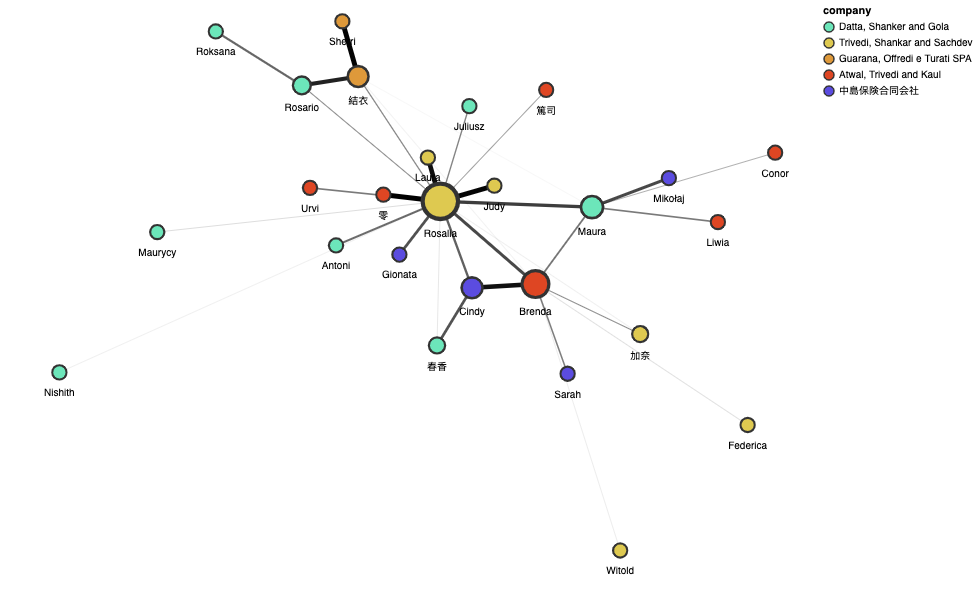

In [4]:
alph(G, **alph_params).configure_view(strokeWidth=0)

Simple customisation - conditionally highlight nodes and edges

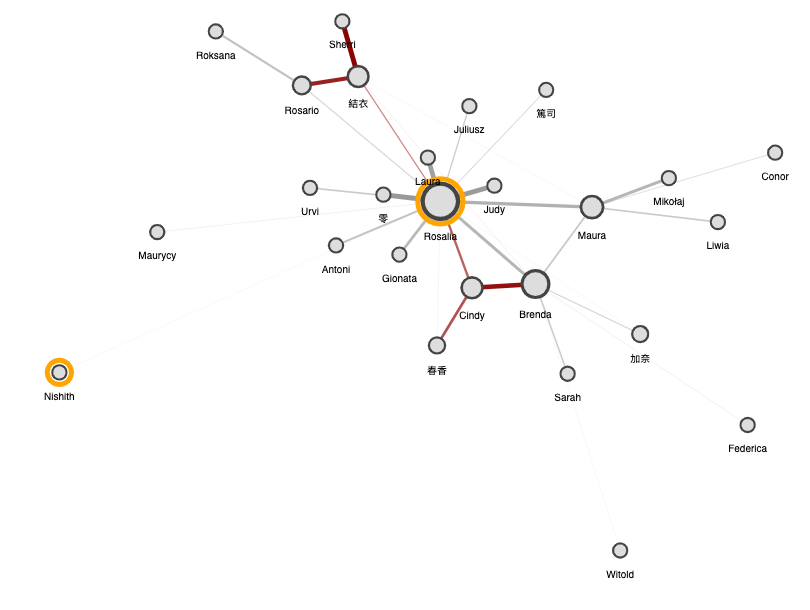

In [5]:
alph(G, **{
    **alph_params,
    **dict(
        node_args={
            **alph_params["node_args"],
            **dict(
                fill="#ddd",
                stroke="#444",
                halo_offset=3,
                halo_opacity=alt.condition(
                    "(datum.name[0] == 'N') || (datum.name == 'Rosalia')",
                    alt.value(1),
                    alt.value(0)
                ),
                halo_stroke="orange",
                halo_strokeWidth=5,
            )
        },
        edge_args={
            **alph_params["edge_args"],
            **dict(
                color=alt.condition(
                    (
                        (alt.datum.source == 3)
                        | (alt.datum.target == 3)
                        | (alt.datum.source == 1)
                        | (alt.datum.target == 1)
                    ),
                    alt.value("darkred"),
                    alt.value("#999")
                ),
            )
        }
    )
}).configure_view(strokeWidth=0)

Combination of two plots altair-style, showing the use of Altair settings

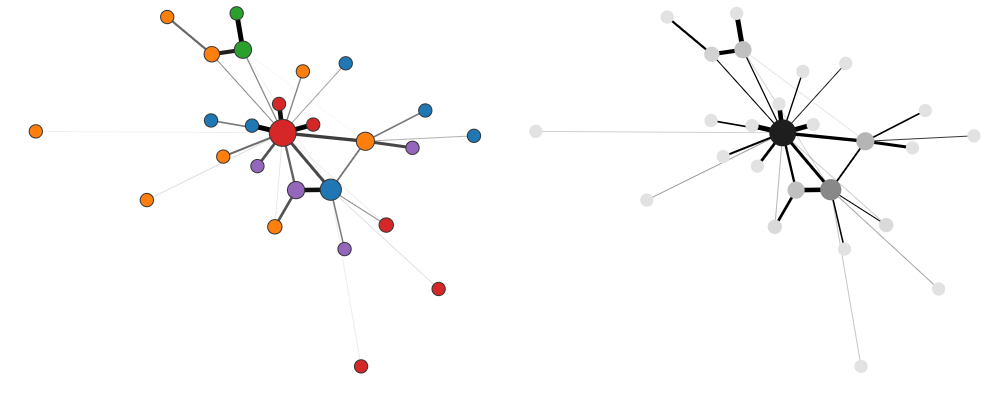

In [6]:
g1 = alph(
    G,
    weight_attr="weight",
    layout_fn=lambda g: nx.spring_layout(g, weight="weight", k=4, iterations=5000, seed=seed),
    node_args=dict(
        size=alt.Size(
            "degree_centrality",
            scale=alt.Scale(domain=[0,1], range=[12**2, 30**2]),
            legend=None
        ),
        fill=alt.Color("company", scale=alt.Scale(scheme="category10"), legend=None),
        stroke="#333",
        strokeWidth=1,
        tooltip_attrs=["name", "company"],
    ),
    edge_args=dict(color="#000"),
    width=600*0.8,
    height=480*0.8,
    padding=20,
)

g2 = alph(
    G,
    weight_attr="weight",
    layout_fn=lambda g: nx.spring_layout(g, weight="weight", k=4, iterations=5000, seed=seed),
    node_args=dict(
        size=alt.Size(
            "degree_centrality",
            scale=alt.Scale(domain=[0,1], range=[12**2, 30**2]),
            legend=None
        ),
        fill=alt.Color("degree_centrality", scale=alt.Scale(scheme="greys"), legend=None),
        strokeWidth=0,
        tooltip_attrs=["name", "company"],
    ),
    edge_args=dict(
        color="#000",
        opacity=1
    ),
    width=600*0.8,
    height=480*0.8,
    padding=20,
)

(g1 | g2).configure_view(strokeWidth=0)